## Import libraries

In [1]:
import pandas_datareader.data as web

In [ ]:
pip install yfinance

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

In [4]:
dt_start = '2015-08-07'
dt_end   = '2021-12-04'
ETH = pdr.get_data_yahoo('ETH-USD', start = dt_start, end = dt_end)
ETH

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329
2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188
2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170
2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100
...,...,...,...,...,...,...
2021-11-30,4447.768066,4753.266113,4358.074219,4631.479004,4631.479004,28626354111
2021-12-01,4623.679688,4780.732422,4530.272461,4586.990234,4586.990234,27634826695
2021-12-02,4586.333008,4628.919922,4441.507812,4511.302246,4511.302246,21502671027


In [5]:
pip install pandas==0.25.1

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import itertools
import warnings
warnings.filterwarnings('ignore')

In [33]:
data_ETH = ETH.drop(columns=['Open', 'High','Low','Close','Volume'])
data_ETH = data_ETH.rename({'Adj Close': 'Adj_Close'}, axis=1)
data_ETH

,Adj_Close
Date,
2015-08-07,2.772120
2015-08-08,0.753325
2015-08-09,0.701897
2015-08-10,0.708448
2015-08-11,1.067860
...,...
2021-11-30,4631.479004
2021-12-01,4586.990234
2021-12-02,4511.302246


In [55]:
data_ETH.shape

(2308, 1)

In [56]:
data_test = data_ETH.ix[1730: ]
data_train = data_ETH.ix[: 1730]

In [57]:
data_train.shape

(1730, 1)

In [58]:
data_test.shape

(578, 1)

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_train)

MinMaxScaler()

In [60]:
data_train

,Adj_Close
Date,
2015-08-07,2.772120
2015-08-08,0.753325
2015-08-09,0.701897
2015-08-10,0.708448
2015-08-11,1.067860
...,...
2020-04-28,198.415390
2020-04-29,216.968231
2020-04-30,207.602051


### Functions required

In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [21]:
def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

In [22]:
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

In [23]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))

### Create a Neural Network

In [24]:
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Train model

In [25]:
def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)
    return model

In [26]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

- Here, the output(y_t) depends on the previous 'p' time steps.
- So, the output layer consists of one unit and input layer layer consists of p units.
- We need to train the model with different number of units in all layers and select the parameters that gives the low RMSE score on test data.

### FNN - Preprocess data: Convert time series into suitable format

In [27]:
def preprocess_FNN(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test

### FNN - Forecast next 'n' timesteps

In [28]:
def forecast_FNN(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1])
    return forecasted_values

### Feed forward Network

In [29]:
def FNN(data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
    X_train, y_train = reshape_arrays(X_train, y_train)

    model_FNN = create_NN(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_FNN = train_model(model_FNN, X_train, y_train, epochs, batch_size)

    input_seq_for_test_FNN = np.reshape(input_seq_for_test_FNN, (1, len(input_seq_for_test_FNN)))
    forecasted_values_FNN = forecast_FNN(model_FNN, input_sequence=input_seq_for_test_FNN, future_steps=future_steps)
    
    forecasted_values_FNN = list(scaler.inverse_transform([forecasted_values_FNN])[0])
    
    return model_FNN, forecasted_values_FNN

### FNN - Get scores on test data

In [34]:
def get_accuracies_FNN(rainfall_data, test_rainfall_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_FNN = []
    iterator = 0
    print('FNN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        look_back = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_FNN, forecasted_values_FNN = FNN(rainfall_data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_rainfall_data.ix[:future_steps].Adj_Close
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_FNN)
        
        info = list(param) + [mse, mae, rmse] + forecasted_values_FNN
        information_FNN.append(info)

    information_FNN_df = pd.DataFrame(information_FNN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_FNN_df.columns = ['look_back', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes
    return information_FNN_df

### TLNN - Preprocess data: Convert time series into suitable format

In [35]:
def preprocess_TLNN(data, time_lagged_points):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(max(time_lagged_points), data.shape[0]):
        x = [data[i-p] for p in time_lagged_points]
        y = data[i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = [data[i+1-p] for p in time_lagged_points]
    return X_train, y_train, input_seq_for_test

### TLNN - Forecast next 'n' timesteps

In [36]:
def forecast_TLNN(model, time_lagged_points, last_sequence, future_steps):
    forecasted_values = []
    max_lag = max(time_lagged_points)
    for i in range(future_steps):
        input_sequence = [last_sequence[max_lag - p] for p in time_lagged_points]
        input_sequence = np.asarray(input_sequence).astype(np.float32)

        forecasted_value = model.predict(np.reshape(input_sequence, (1, len(input_sequence))))
        forecasted_values.append(forecasted_value[0][0])
        last_sequence = last_sequence[1:] + [forecasted_value[0][0]]
    return forecasted_values

### Time Lagged Neural Networks

In [37]:
def TLNN(data, time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_TLNN = preprocess_TLNN(data, time_lagged_points)
    X_train, y_train = reshape_arrays(X_train, y_train)
    model_TLNN = create_NN(input_nodes=len(time_lagged_points), hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_TLNN = train_model(model_TLNN, X_train, y_train, epochs, batch_size)

    max_lag = max(time_lagged_points)
    forecasted_values_TLNN = forecast_TLNN(model_TLNN, time_lagged_points, 
                                      list(data[-max_lag:]), future_steps=future_steps)
    forecasted_values_TLNN = list(scaler.inverse_transform([forecasted_values_TLNN])[0])
    
    return model_TLNN, forecasted_values_TLNN

### TLNN - Get scores on test data

In [38]:
def get_accuracies_TLNN(rainfall_data, test_rainfall_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_TLNN = []
    iterator = 0
    print('TLNN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        time_lagged_points = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_TLNN, forecasted_values_TLNN = TLNN(rainfall_data, time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_rainfall_data.ix[:future_steps].Adj_Close
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_TLNN)
        
        info = list(param) + [mse, mae, rmse] + forecasted_values_TLNN
        information_TLNN.append(info)

    information_TLNN_df = pd.DataFrame(information_TLNN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_TLNN_df.columns = ['look_back_lags', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes
    return information_TLNN_df

In [48]:
def analyze_results(data_frame, test_rainfall_data, name, flag=False):
    optimized_params = data_frame.iloc[data_frame.RMSE.argmin]
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1*int(future_steps):]
    y_true = test_rainfall_data.ix[:int(future_steps)]
    forecast_values.index = y_true.index
    
    print('=== Best parameters of ' + name + ' ===\n')
    if (name == 'FNN' or name == 'LSTM'):
        model = create_NN(optimized_params.look_back, 
                          optimized_params.hidden_nodes, 
                          optimized_params.output_nodes)
        print('Input nodes(p): ' + str(optimized_params.look_back))
        print('Hidden nodes: ' + str(optimized_params.hidden_nodes))
        print('Output nodes: ' + str(optimized_params.output_nodes))
    elif (name == 'TLNN'):
        model = create_NN(len(optimized_params.look_back_lags), 
                          optimized_params.hidden_nodes, 
                          optimized_params.output_nodes)
        s = ''
        for i in optimized_params.look_back_lags:
            s = s+' '+str(i)
        print('Look back lags: ' + s)
        print('Hidden nodes: ' + str(optimized_params.hidden_nodes))
        print('Output nodes: ' + str(optimized_params.output_nodes))
    elif (name == 'SANN'):
        model = create_NN(optimized_params.seasonal_period, 
                          optimized_params.hidden_nodes, 
                          optimized_params.seasonal_period)
        print('Input nodes(s): ' + str(optimized_params.seasonal_period))
        print('Hidden nodes: ' + str(optimized_params.hidden_nodes))
        print('Output nodes: ' + str(optimized_params.seasonal_period))
        
    print('Number of epochs: ' + str(optimized_params.epochs))
    print('Batch size: ' + str(optimized_params.batch_size))
    print('Number of future steps forecasted: ' + str(optimized_params.future_steps))
    print('Mean Squared Error(MSE): ' + str(optimized_params.MSE))
    print('Mean Absolute Error(MAE): ' + str(optimized_params.MAE))
    print('Root Mean Squared Error(RMSE): ' + str(optimized_params.RMSE))
    print('\n\n')
    
    # Save model
    # from keras.utils import plot_model
    # plot_model(model, to_file = STORAGE_FOLDER + name + '_best_fit_model.png', show_shapes=True, show_layer_names=True)
    
    # Save data
    # data_frame.to_csv(STORAGE_FOLDER + name + '_information.csv')
    # optimized_params.to_csv(STORAGE_FOLDER + name + '_optimized_values.csv')
    
    plt.figure(figsize=(10,5))
    plt.plot(y_true, color='green', label='Actual values')
    plt.plot(forecast_values, color='red', label='Forecasted values')
    plt.xlabel('Year')
    plt.ylabel('Monthly mean Sum')
    plt.legend(loc='best')
    if (flag==False):
        plt.title(name + ' - Comaprison: Actual vs Forecasted')
        # plt.savefig(STORAGE_FOLDER + name + '_best_forecast'  + '.png')
    else:
        plt.title('Best of all: ' + name + ' - Comaprison: Actual vs Forecasted')
        # plt.savefig(STORAGE_FOLDER + 'BEST_FORECAST_' + name + '.png')
    
    return optimized_params

## Pick the best method

In [49]:
def best_of_all(list_of_methods):
    RMSE_values = [x.RMSE for x in list_of_methods]
    index = np.argmin(RMSE_values)
    if (index==0):
        name = 'FNN'
    elif (index == 1):
        name = 'TLNN'
    elif (index == 2):
        name = 'SANN'
    else:
        name = 'LSTM'
    print(RMSE_values)
    
    names = ['FNN', 'TLNN', 'SANN', 'LSTM']
    RMSE_info = pd.Series(RMSE_values, index=names)
    
    print('Overall Best method on this data is ' + name)
    return index, name, RMSE_info

## Compare the results of above algorithms based on RMSE score.
- Plots a bar plot comparing the scores of different algorithms.

In [50]:
def compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps):
    
    information_FNN_df = get_accuracies_FNN(rainfall_data, test_rainfall_data, parameters_FNN, scaler)
    optimized_params_FNN = analyze_results(information_FNN_df, test_rainfall_data, 'FNN')
    
    information_TLNN_df = get_accuracies_TLNN(rainfall_data, test_rainfall_data, parameters_TLNN, scaler)
    optimized_params_TLNN = analyze_results(information_TLNN_df, test_rainfall_data, 'TLNN')
    
    information_SANN_df = get_accuracies_SANN(rainfall_data, test_rainfall_data, parameters_SANN, scaler)
    optimized_params_SANN = analyze_results(information_SANN_df, test_rainfall_data, 'SANN')
    
    information_LSTM_df = get_accuracies_LSTM(rainfall_data, test_rainfall_data, parameters_LSTM, scaler)
    optimized_params_LSTM = analyze_results(information_LSTM_df, test_rainfall_data, 'LSTM')
    
    list_of_methods = [optimized_params_FNN, optimized_params_TLNN, optimized_params_SANN, optimized_params_LSTM]
    information = [information_FNN_df, information_TLNN_df, information_SANN_df, information_LSTM_df]
    index, name, RMSE_info = best_of_all(list_of_methods)
    best_optimized_params = analyze_results(information[index], test_rainfall_data, name, True)
    return RMSE_info

## Number of future steps to be forecasted

In [53]:
future_steps = 60

## Initialize all the parameters
- It tries all the combinations of different parameters and selects the optimal parmaters based on the RMSE scores.
- It also finds the best method for this data.

In [51]:
from tensorflow.keras.utils import plot_model

FNN - Number of combinations: 28
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12 -> 13 -> 14 -> 15 -> 16 -> 17 -> 18 -> 19 -> 20 -> 21 -> 22 -> 23 -> 24 -> 25 -> 26 -> 27 -> 28
=== Best parameters of FNN ===

Input nodes(p): 6.0
Hidden nodes: 4.0
Output nodes: 1.0
Number of epochs: 500.0
Batch size: 20.0
Number of future steps forecasted: 60.0
Mean Squared Error(MSE): 213.659
Mean Absolute Error(MAE): 11.992
Root Mean Squared Error(RMSE): 14.617



TLNN - Number of combinations: 16
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12 -> 13 -> 14 -> 15 -> 16
=== Best parameters of TLNN ===

Look back lags:  1 2 3 11 12
Hidden nodes: 3
Output nodes: 1
Number of epochs: 300
Batch size: 20
Number of future steps forecasted: 60
Mean Squared Error(MSE): 252.781
Mean Absolute Error(MAE): 13.665
Root Mean Squared Error(RMSE): 15.899



SANN - Number of combinations: 8
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8
=== Best parameters of SANN ===

Input nodes(s): 12.0
Hidden nodes: 3.0

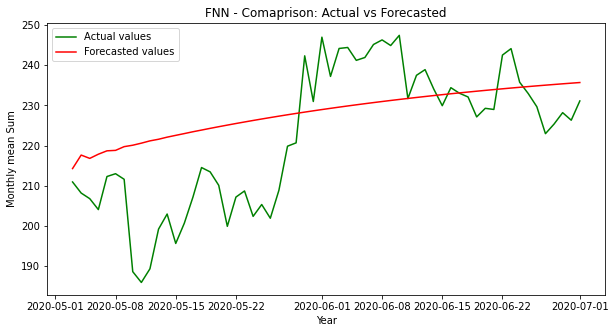

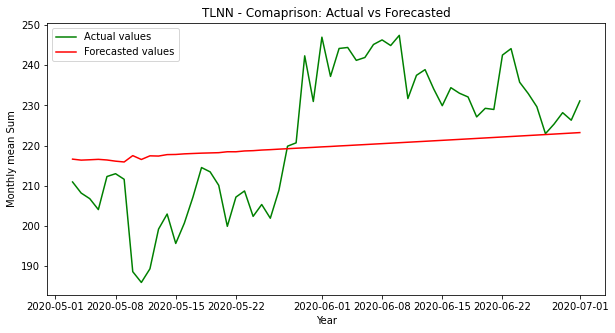

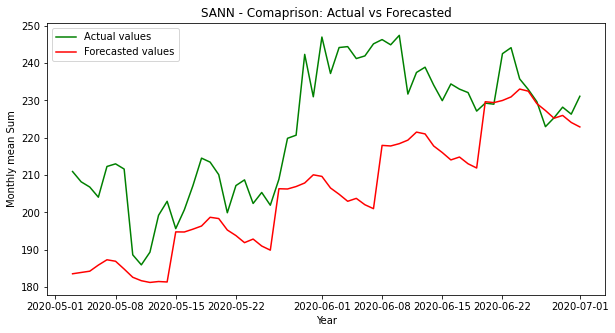

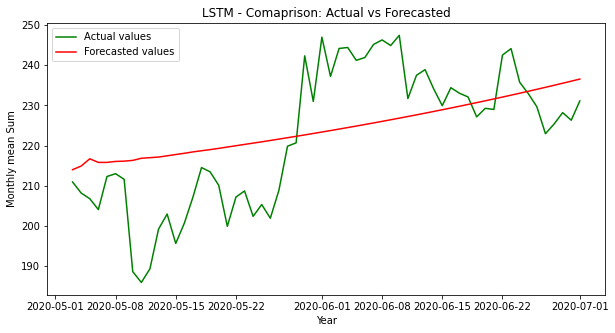

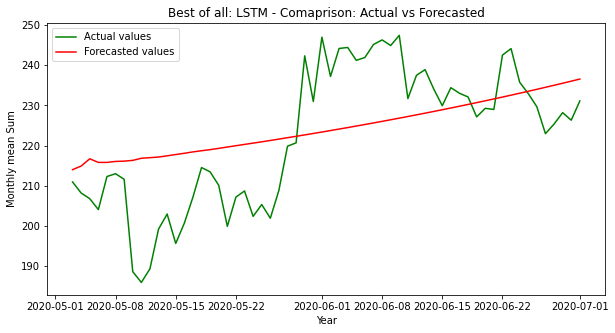

In [61]:
# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_FNN = [[1,2,3,6,8,10,12], [3,4,5,6], [1], [500], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,11,12,13], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6,7,8,9,10], [500], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[1,2,3,4,5,6,7,8,9,10,11,12,13], [3,4,5,6], [1], [300], [20], [future_steps]]

RMSE_info = compare_ANN_methods(data_train, data_test, scaler, 
                    parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps)

In [62]:
RMSE_info

FNN     14.617
TLNN    15.899
SANN    20.336
LSTM    13.736
dtype: float64

## Plot RMSE scores

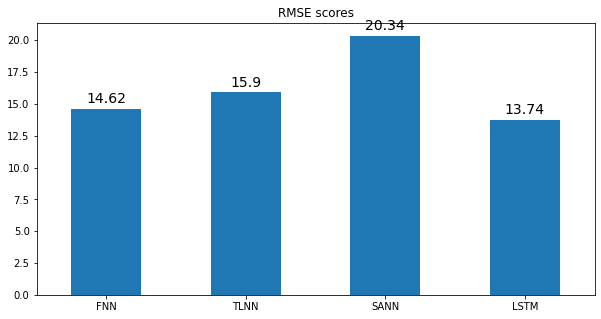

In [63]:
ax = RMSE_info.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

- If we compare the results, LSTM worked better than all the methods on this data.